In [126]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/MW-timestamp-NEW.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [ ]:
dataDF.describe().toPandas().transpose()

In [5]:
dataDF.count()

1587257

In [6]:
#Down sample to take every 10th value
filtered = dataDF.filter((dataDF.rowID % 10) == 0)

In [7]:
filtered.count()

158726

In [8]:
#SELECT required columns and drop rows with NULL

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

workingDF = filtered.select(cols).na.drop()

In [9]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [10]:
#CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [11]:
workingDF.columns

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [12]:
#ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [13]:
#SCALE the dataset.

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)

# Fit the StandardScaler
scalerModel = scaler.fit(assembled)

# Normalize each feature
scaledData = scalerModel.transform(assembled)

In [143]:
#Perform Clustering.

from pyspark.ml.clustering import KMeans
howManyClusters = 12

# Trains a k-means model.
kmeans      = KMeans(k=howManyClusters, seed = 1)
model       = kmeans.fit(scaledData)
transformed = model.transform(scaledData)
featuresAndPrediction     = transformed.select("features", "prediction")

In [146]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|            10573|
|         1|            13422|
|         2|            14833|
|         3|            18638|
|         4|             4633|
|         5|            15793|
|         6|            11535|
|         7|            18995|
|         8|            25630|
|         9|            11968|
|        10|             2249|
|        11|            10411|
+----------+-----------------+



In [147]:
# Print cluster centers.

print(cols)
#allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]

print("\nCLUSTER CENTERS: \n")
for center in model.clusterCenters():
    print(center)

['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed', 'relative_humidity']

CLUSTER CENTERS: 

[ 1.3043177  -0.24030114 -1.15387809  1.73371066 -1.04692201  1.83870394
 -1.12200481]
[ 0.15751205 -0.74345552 -1.21984653 -0.54988543 -1.07080566 -0.56542011
  0.76523163]
[-0.84408569 -1.18714659  0.35906729  0.37705119  0.48557782  0.3622125
  1.3504302 ]
[-0.22585128  0.64177068  0.40939938  0.70750203  0.51838698  0.64736436
 -0.14786832]
[ 0.1316567   0.84599709  1.89333604 -0.62811164 -1.54748661 -0.55455231
 -0.75396777]
[ 0.20473291 -0.9831286   0.6422715  -0.54885846  0.8595796  -0.53230441
  1.16837617]
[ 0.97090599  0.23516064  0.21466114 -0.49957322  0.40200752 -0.5031493
 -0.80817985]
[-0.61793223  0.61682555  0.13398891 -0.6199921   0.30534198 -0.63439095
 -0.19456452]
[ 0.28451552  0.6349466  -1.30641379 -0.47416785 -1.167003   -0.48287242
 -0.79755924]
[ 0.13321964  0.86068327  1.37398803 -0.63856793  1.63826957 -0.58949

In [148]:
# This function evaluates WSSE  -  Within Set Sum of Squared Errors.

from numpy import array
from math import sqrt

def wssse(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        return sqrt(sum([x*x for x in (point - center)]))
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [149]:
# print(wssse(featuresAndPrediction, model))

213756.874047


In [158]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,3):
    #train kmeans
    print('Training for k = ',  howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    model       = kmeans.fit(scaledData)
    transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    print("Calculating WSSSE")
    W = wssse(featuresAndPrediction, model)
    print(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

('Training for k = ', 2)
Calculating WSSSE
348521.951115


## Plots

In [216]:
from pandas.tools.plotting import parallel_coordinates
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [217]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [222]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)

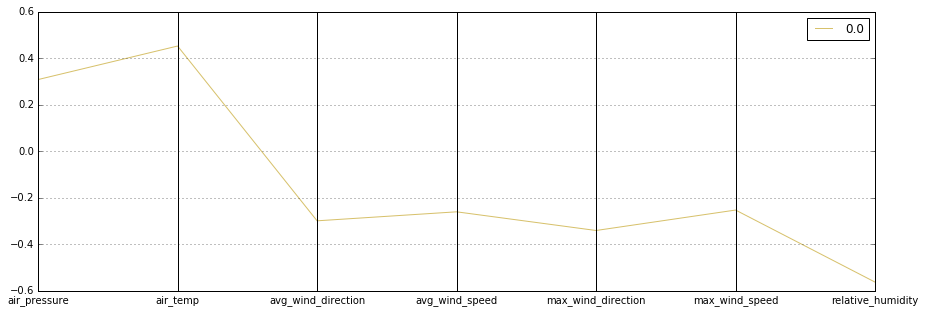

In [219]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,5))

dryClusters = [0]

parallel_coordinates(P.iloc[dryClusters], 'prediction')

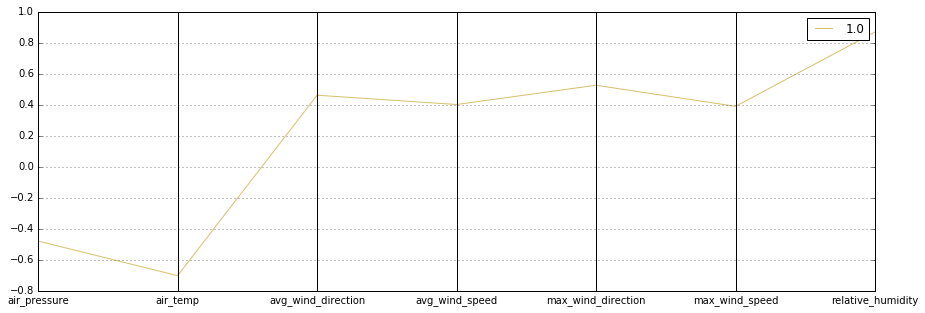

In [220]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,5))

warmClusters = [1]

parallel_coordinates(P.iloc[warmClusters], 'prediction')

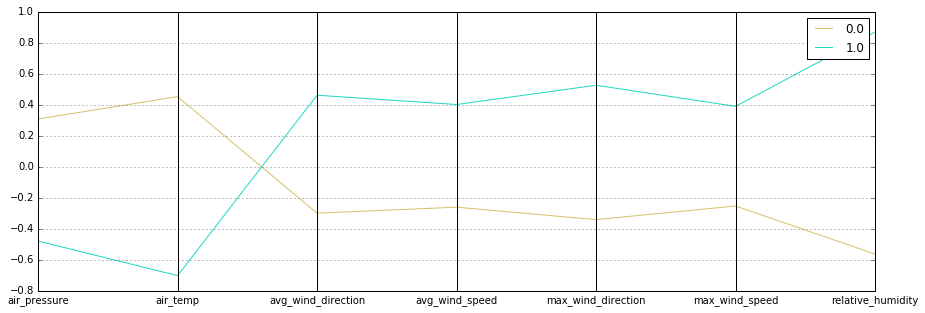

In [221]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,5))

coolAndRainy = [0,1]

parallel_coordinates(P.iloc[coolAndRainy], 'prediction')